In [3]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, sampler

In [4]:
# data loader
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = datasets.MNIST(root='data',train=True, transform=transform,download=True)
test_dataset = datasets.MNIST(root='data',train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256, )

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6054975.95it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 159299.36it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 603916.74it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4837615.23it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break


Training Set:

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])


## Model

In [20]:
# Custom reshape class
class Reshape(nn.Module):
    def __init__(self,*args):
        super(Reshape,self).__init__()
        self.shape = args
    def forward(self,x):
        with_new_shape = x.view(self.shape)
        return with_new_shape
class Trim(nn.Module):
    def __init__(self,*args):
        super(Trim, self).__init__()

    def forward(self,x):
        return x[:, :, :28, :28]


class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,3, stride=1, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32,64,3,stride=2,padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64,64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64,64, 3, stride=1, padding=1),
            nn.Flatten()
        )
        self.z_mean = torch.nn.Linear(3136,2)
        self.z_log_var = torch.nn.Linear(3136,2)

        self.decoder = nn.Sequential(
            nn.Linear(2,3136),
            Reshape(-1,64,7,7),
            nn.ConvTranspose2d(64,64, 3, stride=1, padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64,64,3, stride=2, padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64,32,3, stride=2, padding=0),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(32,1,3 ,stride=1, padding=0),
            Trim(),
            nn.Sigmoid()


        )
    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
    def reparameterize(self, mean, log_var):
        eps = torch.randn(mean.size(0),mean.size(1)).to(mean.get_device() )
        sigma = torch.exp(log_var/2.0)
        z = mean+sigma*eps
        return z

    def forward(self,x):
        x=  x.view((-1,1,28,28))
        encoded=self.encoder(x)
        mean = self.z_mean(encoded)
        log_variance = self.z_log_var(encoded)
        encoded_z  = self.reparameterize(mean, log_variance)
        decoded=self.decoder(encoded_z)
        return encoded, mean, log_variance, decoded



## Training Setup

In [ ]:

def compute_epoch_loss_autoencoder(model, data_loader, loss_fn, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            features = features.to(device)
            logits = model(features)
            loss = loss_fn(logits, features, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [ ]:
import time
log_dict = {'train_combined_loss_per_epoch': [],
           'train_combined_loss_per_batch':[],
           'train_reconstruction_loss_per_batch':[],
           'train_kl_loss_per_batch':[]}
loss_fn = F.mse_loss
start_time = time.time()
def train_vae(num_epochs, model, optimizer, device, train_loader,
             loss_fn=None,
             logging_interval=100,
             skip_epoch_stats=False,
             reconstruction_term_weight=1,
             save_model=None):
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):
            features = features.to(device)

            _, mean, log_var, reconstruction=model(features)
            # print(mean.get_device())

            # KL Div Loss
            kl_loss=torch.sum(-0.5*(1+log_var - mean**2 - torch.exp(log_var)),axis=1)
            batch_size=kl_loss.size(0)

            kl_loss_avg = kl_loss.mean()
             ## Reconstruction Loss
            if loss_fn is None:
              loss_fn = F.mse_loss
            # print(reconstruction.get_device())
            # print(features.get_device())
            reconstruction_loss = loss_fn(reconstruction, features,reduction='none')
            reconstruction_loss = reconstruction_loss.view(batch_size, -1).sum(axis=1)
            reconstruction_loss=reconstruction_loss.mean()

            total_loss = reconstruction_loss+kl_loss_avg
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(total_loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(reconstruction_loss.item())
            log_dict['train_kl_loss_per_batch'].append(kl_loss_avg.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                          % (epoch+1, num_epochs, batch_idx,
                              len(train_loader), total_loss))
        if not skip_epoch_stats:
                model.eval()

                with torch.set_grad_enabled(False):  # save memory during inference

                    train_loss = compute_epoch_loss_autoencoder(
                        model, train_loader, loss_fn, device)
                    print('***Epoch: %03d/%03d | Loss: %.3f' % (
                          epoch+1, num_epochs, train_loss))
                    log_dict['train_combined_per_epoch'].append(train_loss.item())
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return log_dict

In [ ]:
#instantiate VAE
torch.manual_seed(2342)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=VAE()
model.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0005)
save_path='/content/drive/MyDrive/model_params/model_vae.pt'

log_dict = train_vae(num_epochs=50, model=model,
                        optimizer=optimizer, device=device,
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50,
                     save_model=save_path)


import pickle

# Save the list of tensors to a file
with open(r'/content/drive/MyDrive/model_params/log_dict_vae_mnist.pkl', 'wb') as file:
    pickle.dump(log_dict, file)

Epoch: 001/050 | Batch 0000/0235 | Loss: 225.4168
Epoch: 001/050 | Batch 0050/0235 | Loss: 58.2663
Epoch: 001/050 | Batch 0100/0235 | Loss: 52.5989
Epoch: 001/050 | Batch 0150/0235 | Loss: 52.4529
Epoch: 001/050 | Batch 0200/0235 | Loss: 51.2659
Time elapsed: 1.84 min
Epoch: 002/050 | Batch 0000/0235 | Loss: 46.5115
Epoch: 002/050 | Batch 0050/0235 | Loss: 47.1010
Epoch: 002/050 | Batch 0100/0235 | Loss: 43.1624
Epoch: 002/050 | Batch 0150/0235 | Loss: 44.6075
Epoch: 002/050 | Batch 0200/0235 | Loss: 46.3845
Time elapsed: 2.01 min
Epoch: 003/050 | Batch 0000/0235 | Loss: 42.8215
Epoch: 003/050 | Batch 0050/0235 | Loss: 44.8058
Epoch: 003/050 | Batch 0100/0235 | Loss: 41.0650
Epoch: 003/050 | Batch 0150/0235 | Loss: 43.3317
Epoch: 003/050 | Batch 0200/0235 | Loss: 44.7489
Time elapsed: 2.18 min
Epoch: 004/050 | Batch 0000/0235 | Loss: 41.4757
Epoch: 004/050 | Batch 0050/0235 | Loss: 43.4222
Epoch: 004/050 | Batch 0100/0235 | Loss: 40.2434
Epoch: 004/050 | Batch 0150/0235 | Loss: 42.7269

## Evaluation

In [8]:
# load log_dict
import pickle
with open(r'/content/drive/MyDrive/model_params/log_dict_vae_mnist.pkl', 'rb') as file:
    log_dict = pickle.load(file)
log_dict.keys()

dict_keys(['train_combined_loss_per_epoch', 'train_combined_loss_per_batch', 'train_reconstruction_loss_per_batch', 'train_kl_loss_per_batch'])

In [13]:
import numpy as np
import matplotlib.colors as mcolors


In [17]:
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

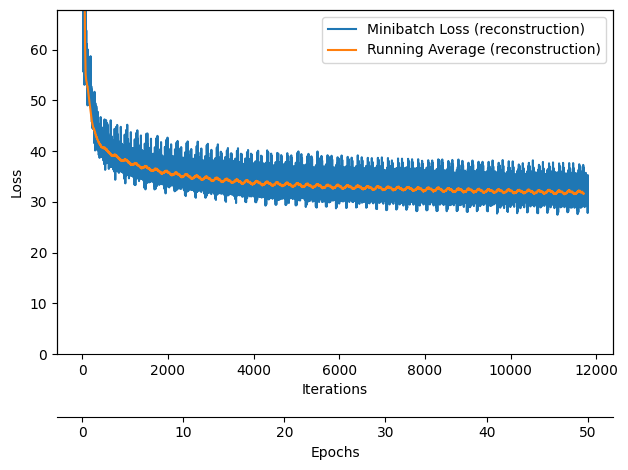

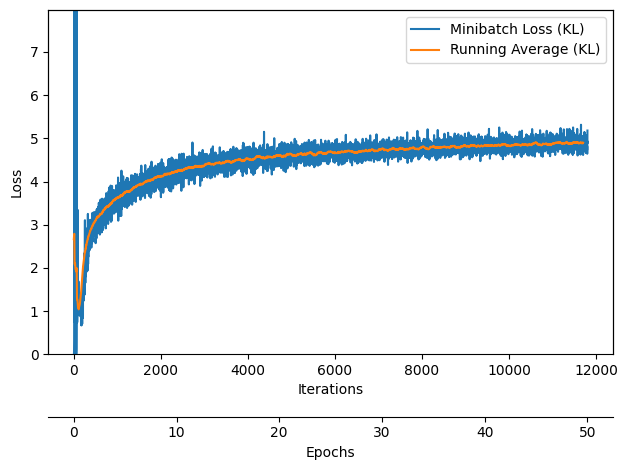

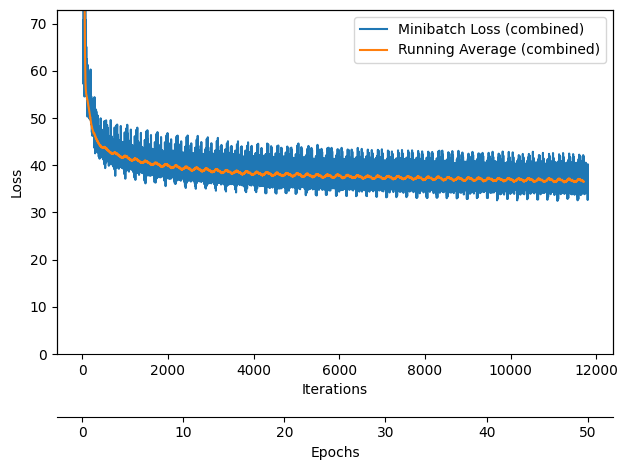

In [18]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], num_epochs=50, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], num_epochs=50, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], num_epochs=50, custom_label=" (combined)")
plt.show()

In [19]:
# Ploting latent space
def plot_latent_space_with_labels(num_classes, data_loader, encoding_fn, device):
    d = {i:[] for i in range(num_classes)}

    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)

            embedding = encoding_fn(features)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask].to('cpu').numpy())

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()

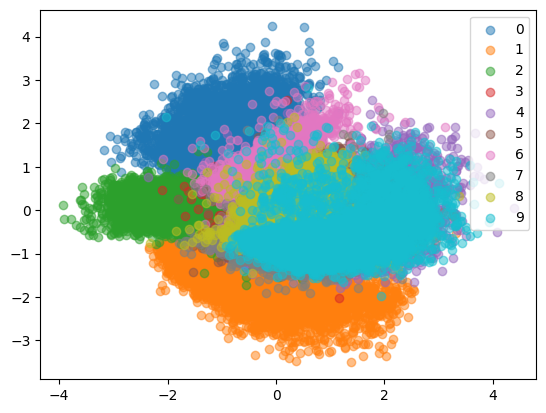

In [25]:
save_path=r'/content/drive/MyDrive/model_params/model_vae.pt'
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE()
model.to(device)
model.load_state_dict(torch.load(save_path))
model.eval()
plot_latent_space_with_labels(
    num_classes=10,
    data_loader=train_loader,
    encoding_fn=model.encoding_fn,
    device=device)

plt.legend()
plt.show()

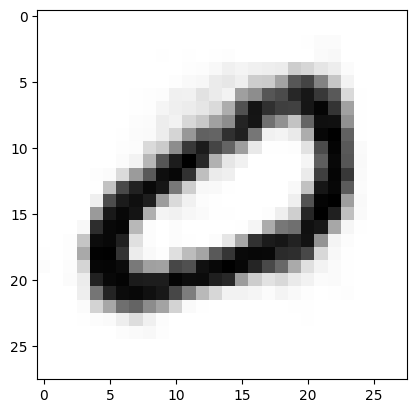

In [31]:
# Generating new imae
with torch.no_grad():
    new_image = model.decoder(torch.tensor([-4.0, 2.0]).to(device))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()